In [1]:
# pip install langdetect

In [2]:
# pip install XGBoost

In [3]:
# pip install googletrans

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions/text.csv


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings("ignore")

## Set Plot Parameters
sns.set(color_codes=True)        
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)

In [7]:
df_input=pd.read_csv('/kaggle/input/emotions/text.csv')

In [8]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


### Text preprocessing

In [9]:
# #Remove special characters/links
# import re
# def text_cleaner(x):
#     text=re.sub("[@&][A-Za-z0-9_]+","", x)     # Remove mentions
#     text=re.sub(r"http\S+","", text)           # Remove website links if any
#     return  pd.Series([text])

# df_input[['plain_text']] = df_input.text.apply(text_cleaner)

# #Convert all text to lowercase
# df_input.plain_text = df_input.plain_text.str.lower()

# #Remove newline character
# df_input.plain_text = df_input.plain_text.str.replace('\n', '')

# #Replacing any empty strings with null
# df_input = df_input.replace(r'^\s*$', np.nan, regex=True)
# if df_input.isnull().sum().plain_text == 0:
#    print ('no empty strings')
# else:
#    df_input.dropna(inplace=True)

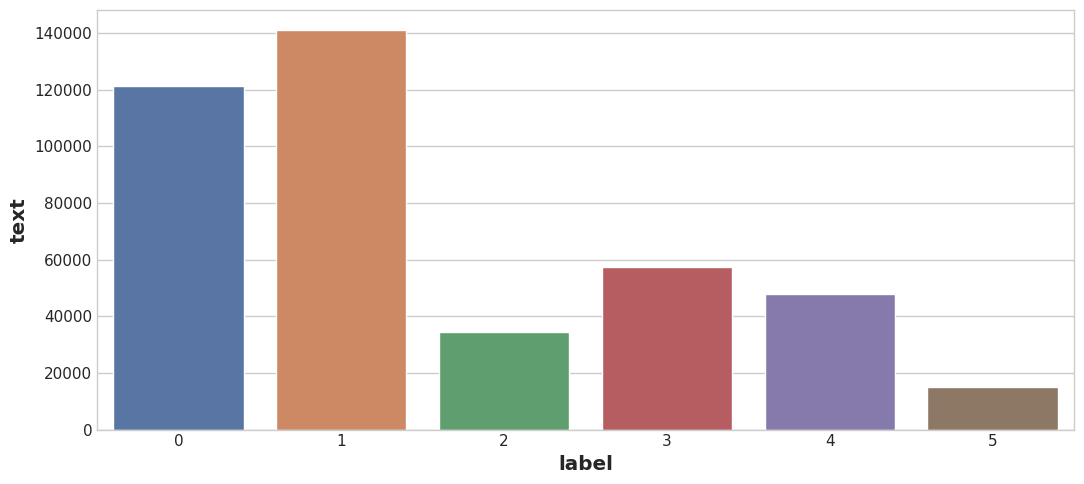

In [10]:
df_agg=df_input.groupby('label')['text'].count().reset_index()
sns.barplot(data=df_agg,x="label",y='text')
plt.show()

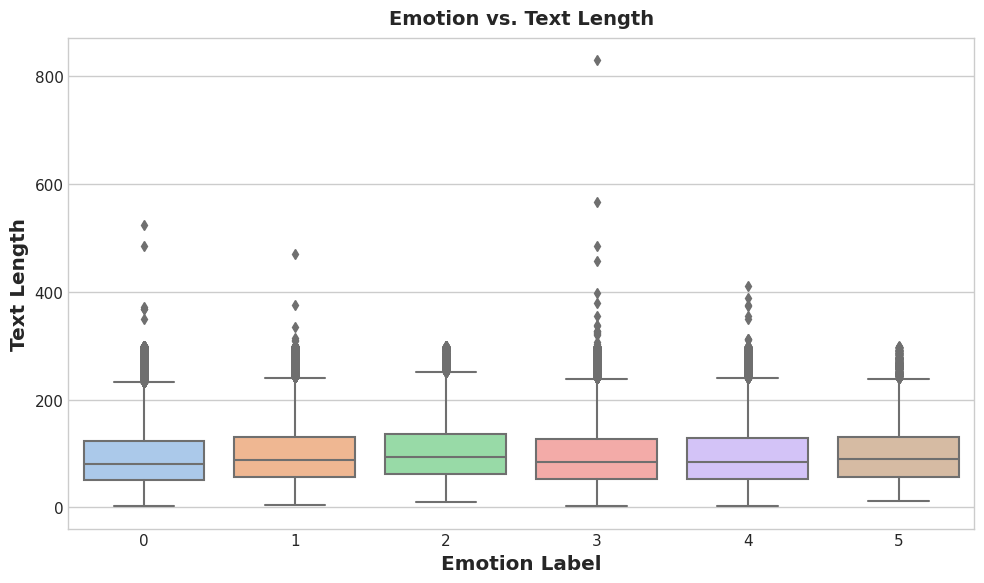

In [11]:
df_input['len']=df_input['text'].apply(lambda x:len(x))
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='len', data=df_input, palette='pastel')
plt.title('Emotion vs. Text Length')
plt.xlabel('Emotion Label')
plt.ylabel('Text Length')
plt.show()

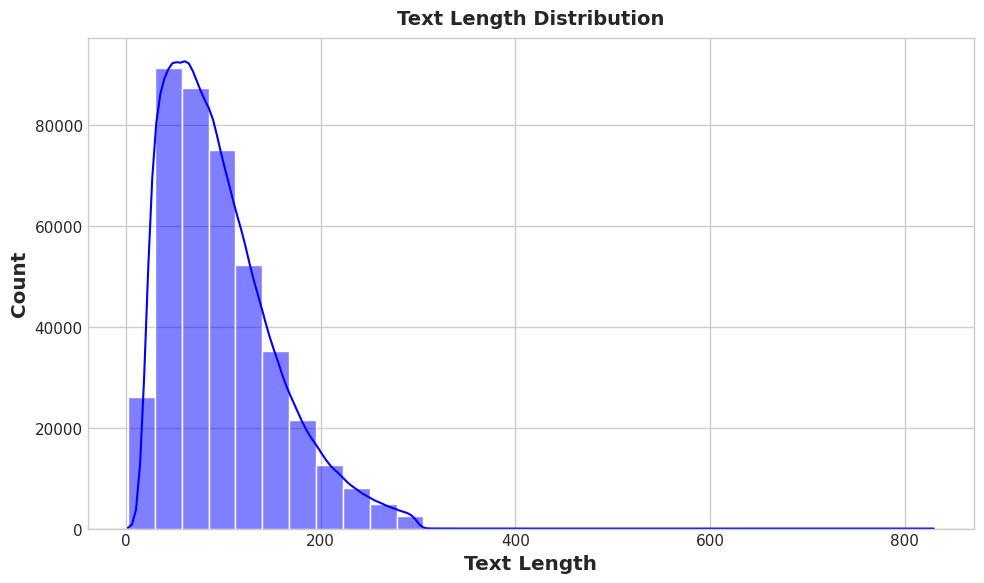

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df_input, x='len', bins=30, kde=True, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()


In [13]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

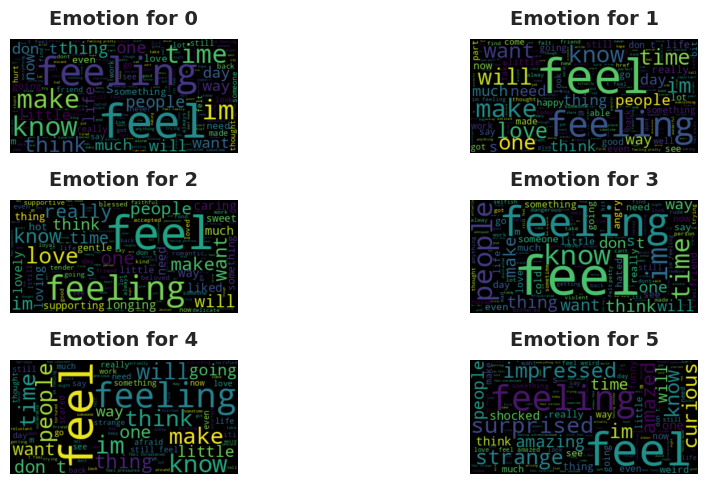

In [15]:
# Start with one review:
unique_emotions = df_input.label.unique()
unique_emotions.sort()

for emotion in unique_emotions:
    ## Filtering the text with similar emotion
    df_subset=df_input[df_input['label']==emotion]
    text="".join(df_subset['text'])
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    # Display the generated image:
    plt.subplot(3,2,emotion+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Emotion for {emotion}")
    plt.axis('off')
plt.show()

#### Data processing for modeling

In [16]:
X=df_input['text']
y=df_input['label']

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.33, random_state=0)

In [18]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(279262,) (137547,) (279262,) (137547,)


#### Vectorization of text to identify emotions

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#### XGBoost

In [20]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=6, random_state=42)
xgb_model.fit(X_train_vec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=6,
              num_parallel_tree=None, ...)

In [21]:
y_pred = xgb_model.predict(X_test_vec)

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Model Evaluation:
Accuracy: 0.8931710615280595

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93     39913
           1       0.92      0.89      0.91     46584
           2       0.74      0.93      0.83     11428
           3       0.93      0.87      0.90     19022
           4       0.86      0.85      0.86     15636
           5       0.69      0.93      0.79      4964

    accuracy                           0.89    137547
   macro avg       0.85      0.90      0.87    137547
weighted avg       0.90      0.89      0.89    137547


Confusion Matrix:
 [[36231  1750   258   601   859   214]
 [  590 41638  3207   277   318   554]
 [   97   623 10597    48    34    29]
 [ 1068   629    87 16466   722    50]
 [  350   440    61   254 13311  1220]
 [   34   111    28     7   174  4610]]


#### Naive Bayes

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Train a Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train)

# Predict the labels for the test set
y_pred = classifier.predict(X_test_vec)

# Print a classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     39913
           1       0.90      0.91      0.91     46584
           2       0.79      0.77      0.78     11428
           3       0.91      0.88      0.90     19022
           4       0.85      0.85      0.85     15636
           5       0.78      0.71      0.74      4964

    accuracy                           0.89    137547
   macro avg       0.86      0.84      0.85    137547
weighted avg       0.89      0.89      0.89    137547

